# Students
**Emilie Hastrup-Kiil** - 379455

**Julian Staab** - 378595

In [2]:
import numpy as np
import pandas as pd
from gurobipy import *

# For progress bar
# Instead of writing...
# > for i in some_list:
# You can write....
# > for i in tqdm(some_list):
# And you will get a very nice progress bar. This is very nice for 
# for-loops that run a long time, like running an optimization model for 
# many timesteps :)
from tqdm.auto import tqdm, trange  

# Plotting libaries - Feel free to use any others of your choice
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.style as style
style.use('fivethirtyeight')

# Enable high resolution plots
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

# HINT  
I recommend that you read through this notebook once *before* you start coding - you can do it all on your own but if you adhere to the structure that we hint at in this notebook, it might be easier for you

## Reading data  
This data is pretty clean but there are some surprises... I recommend that you re-index the dataframe with a [datetime-index](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DatetimeIndex.html) since they have some very convienient attributes and methods which you will need (unless you want to put more effort into this).  
So for example the entries "01-01-2019", "00 - 01" should be changed so that this row has a datetime index "2019-01-01 00:00:00"

In [3]:
import datetime
def read_ElspotPrices(filename):
    
    # Read file, exlude first two rows of data set
    df = pd.read_html(filename, decimal=',', thousands='.', header=2)[0]
    df.rename( columns={'Unnamed: 0':''}, inplace=True )
    
    # Format hours and datetime correctly and combine in the index column
    for index, row in df.iterrows():
        df.loc[index, 'Hours'] = datetime.timedelta(hours=int(row['Hours'].split("-")[1])-1)
        df.loc[index, ''] = datetime.datetime.strptime(row[''], '%d-%m-%Y')
        df.loc[index, ''] = df.loc[index, 'Hours'] + df.loc[index, '']
        
    # Set intex column and remove hours column
    df = df.set_index('')
    df = df.drop(['Hours'], axis=1)
    
    return df # Returning a pandas dataframe

In [4]:
path = "elspot-prices_2019_hourly_eur.xls"
df = read_ElspotPrices(path) # You can rename variables
df.head()

,SYS,SE1,SE2,SE3,SE4,FI,DK1,DK2,Oslo,Kr.sand,...,AT,AT.1,BE,BE.1,DE-LU,DE-LU.1,FR,FR.1,NL,NL.1
,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,44.55,28.32,28.32,28.32,28.32,28.32,28.32,28.32,48.77,48.77,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-01 01:00:00,44.07,10.07,10.07,10.07,10.07,10.07,10.07,10.07,49.25,49.25,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-01 02:00:00,41.12,10.03,10.03,10.03,10.03,10.03,-4.08,-4.08,49.17,49.17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-01 03:00:00,38.88,4.56,4.56,4.56,4.56,4.56,-9.91,-9.91,48.37,48.37,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-01 04:00:00,35.70,4.83,4.83,4.83,4.83,4.83,-7.41,-7.41,47.19,47.19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Daylight savings time  
The data from Elspot contains one hour twice and one hour is missing, thanks to daylight savings time. You have to convert the data so that the timezone is without daylight savings (so no hours exist twice or are missing).
You should also convert the data to UTC+0. The Nordpool headquarters are in norway (CET with summer time, so during the summer they have UTC+2 and during winter UTC+1). 
Below an example of the day light savings switch and how it should look like after you converted the time.  
Hint: You can use pandas functions for this, it can be done in three lines of code 

In [5]:
# Find the day light savings switch with duplicated datetime (clocks turned back for 1 hour)
# You can remove this cell if you want
timediffs = pd.Series(df.index).diff() # Calculate time difference between indices
daylight_idx = timediffs[timediffs == pd.Timedelta(0)].idxmax() #  Find row with no time-difference 
df[daylight_idx-2:daylight_idx+2] # Show the rows surrounding this row

,SYS,SE1,SE2,SE3,SE4,FI,DK1,DK2,Oslo,Kr.sand,...,AT,AT.1,BE,BE.1,DE-LU,DE-LU.1,FR,FR.1,NL,NL.1
,,,,,,,,,,,,,,,,,,,,,
2019-10-27 01:00:00,33.84,31.68,31.68,31.68,31.68,31.68,27.11,27.11,37.12,37.12,...,NaN,32.01,NaN,26.30,NaN,-34.57,NaN,27.30,NaN,27.11
2019-10-27 02:00:00,33.43,31.46,31.46,31.46,31.46,31.46,9.04,9.04,37.11,37.11,...,NaN,31.07,NaN,14.25,NaN,-29.97,NaN,21.13,NaN,25.00
2019-10-27 02:00:00,33.18,31.49,31.49,31.49,31.49,31.49,0.05,0.05,37.11,37.11,...,NaN,31.05,NaN,25.81,NaN,-9.97,NaN,11.58,NaN,25.70
2019-10-27 03:00:00,33.05,31.12,31.12,31.12,31.12,31.12,0.12,0.12,37.08,37.08,...,NaN,31.04,NaN,22.76,NaN,0.12,NaN,14.03,NaN,22.86


In [6]:
# Store the timestamps of the change points of daylight saving time
daylight_saving_start_idx = df[daylight_idx:daylight_idx+1].index
daylight_saving_end_idx = df.index[np.isnan(df.iloc[:, 0])]

# Mark each row as either within the daylight saving time or not
dst=[]
dst_ended = False
for index, row in df.iterrows():
    
    # During summer we don't have daylight saving time
    if index >= daylight_saving_end_idx and index < daylight_saving_start_idx:
        dst.append(False)
        
    # One of the duplicate timestamps is within the daylight saving time and the other not
    elif index == daylight_saving_start_idx and not dst_ended:
        dst.append(True)
        dst_ended = True
    
    # During winter we hav daylight saving time
    elif index == daylight_saving_start_idx and dst_ended:
        dst.append(False)
        dst_ended = True
    else:
        dst.append(True)
    

In [7]:
def removeDaylightSavings(df):
    
    # Indicate the current time zone and daylight saving time
    df.index = df.index.tz_localize('CET', ambiguous=dst, nonexistent='shift_forward')
    
    # Convert to neutral time zone
    df.index = df.index.tz_convert(None) 
    
    return df

In [8]:
df = removeDaylightSavings(df)
df[daylight_idx-2:daylight_idx+2]

,SYS,SE1,SE2,SE3,SE4,FI,DK1,DK2,Oslo,Kr.sand,...,AT,AT.1,BE,BE.1,DE-LU,DE-LU.1,FR,FR.1,NL,NL.1
,,,,,,,,,,,,,,,,,,,,,
2019-10-26 23:00:00,33.84,31.68,31.68,31.68,31.68,31.68,27.11,27.11,37.12,37.12,...,NaN,32.01,NaN,26.30,NaN,-34.57,NaN,27.30,NaN,27.11
2019-10-27 00:00:00,33.43,31.46,31.46,31.46,31.46,31.46,9.04,9.04,37.11,37.11,...,NaN,31.07,NaN,14.25,NaN,-29.97,NaN,21.13,NaN,25.00
2019-10-27 01:00:00,33.18,31.49,31.49,31.49,31.49,31.49,0.05,0.05,37.11,37.11,...,NaN,31.05,NaN,25.81,NaN,-9.97,NaN,11.58,NaN,25.70
2019-10-27 02:00:00,33.05,31.12,31.12,31.12,31.12,31.12,0.12,0.12,37.08,37.08,...,NaN,31.04,NaN,22.76,NaN,0.12,NaN,14.03,NaN,22.86


This is how your data should be formated that you use as input for the "prediction generator":  
* pd.Series() containing the prices for your market area
* index should be of type datetime -> This will make it much easier to create your plots later

In [9]:
example = df["SE1"]
example


2018-12-31 23:00:00    28.32
2019-01-01 00:00:00    10.07
2019-01-01 01:00:00    10.03
2019-01-01 02:00:00     4.56
2019-01-01 03:00:00     4.83
                       ...  
2019-12-31 18:00:00    32.37
2019-12-31 19:00:00    31.23
2019-12-31 20:00:00    31.33
2019-12-31 21:00:00    31.46
2019-12-30 22:00:00    30.83
Name: SE1, Length: 8761, dtype: float64

In [10]:
df.index

DatetimeIndex(['2018-12-31 23:00:00', '2019-01-01 00:00:00',
               '2019-01-01 01:00:00', '2019-01-01 02:00:00',
               '2019-01-01 03:00:00', '2019-01-01 04:00:00',
               '2019-01-01 05:00:00', '2019-01-01 06:00:00',
               '2019-01-01 07:00:00', '2019-01-01 08:00:00',
               ...
               '2019-12-31 13:00:00', '2019-12-31 14:00:00',
               '2019-12-31 15:00:00', '2019-12-31 16:00:00',
               '2019-12-31 17:00:00', '2019-12-31 18:00:00',
               '2019-12-31 19:00:00', '2019-12-31 20:00:00',
               '2019-12-31 21:00:00', '2019-12-30 22:00:00'],
              dtype='datetime64[ns]', name='', length=8761, freq=None)

## "Predicting" future prices  
Since this is not a data science course, we will compare two very simple "prediction" methods:  
1) We perfectly know future prices  
2) Assume price will be the same as last weeks price at the same time  
  
If you want, you can also implement more elaborate prediction methods - you may be able to beat the results from 2) but you should not be able to beat 1)   
In case you implement another predictor, you should obviously only use the prices up to t-1 to predict prices for t to t + n :)

In [11]:
# You do not have to touch this code
class PredictionGenerator():
    def __init__(self, timeseries, method="perfect"):
        self.setMethod(method)
        self.df = timeseries

    # If you use more elaborate prediction methods, you might have to fit a model to the data
    # Implementing another prediction method will not better your grade, so ignore this if you want.
    def fit(self, end_date):
        pass

    # "Predict" prices for some date range defined by a start date and a number of hours
    def predict(self, start_date, nhours):
        dates = pd.date_range(
            start=start_date,
            periods=nhours,
            freq="H")

        if self.method == "Perfect":
            if dates.max() not in self.df.index: # check if prices known
                raise Exception(("You can not forecast the *future* perfectly "
                                 "out of sample! Some of the dates requested "
                                 "are not in the given dataset."))
            result = self.df.loc[dates]  # the actual observed prices
        elif self.method == "SameHourLastWeek":
            min_date = (dates.min() + pd.DateOffset(hours=-7*24))
            max_date = (dates.max() + pd.DateOffset(hours=-7*24))
            if (min_date not in self.df.index) or (max_date not in self.df.index):
                raise Exception(("For some of the dates you tried to predict, "
                                 "there is no data from the week before available."))
            # Last weeks prices
            result = self.df.loc[dates + pd.DateOffset(hours=-7*24)]
            result.index = dates
            
        return result

    
    # Set method if known, otherwise raise exception
    def setMethod(self, method):
        methods = ["Perfect", "SameHourLastWeek"]
        if method not in methods:
            raise Exception(f"Method passed({method}) is not in ["
                            + ", ".join(methods) + "]")
        self.method = method

In [12]:
# Example how to use:
# Create predictor
prediction_method = "SameHourLastWeek" # methods = ["Perfect", "SameHourLastWeek"]
prices = df["SE1"] # All prices that we have for the market area of interest as a Series
predictor = PredictionGenerator(prices, method=prediction_method)
# "Predict" prices for some time frame
t_start = pd.Timestamp("2019-10-22 00:00:00")
predicted_prices = predictor.predict(t_start, 10) # returns a series of "predicted" prices
                                                  # for the 10 hours starting on t_start

## The gurobi model  

In [13]:
def solve(prices,                
          Pmax,
          Emax,
          E0,
          print_result=False):
    
    # Create model
    model = Model("Aluminum DSM")
    model.modelSense = GRB.MINIMIZE
    
    #--------------------------------------------------------------------------------
    
    # Flag decides whether output is printed
    if not print_result:
        model.setParam('OutputFlag', False)
    
    P={}
    E={}
    # Create variables for power and energy deviations from nominal
    for t in prices.index:
        P[t] = model.addVar(lb=-Pmax,name="P%s" % t)
        E[t] = model.addVar(lb=-Emax,name="E%s" % t)
        
    # Make variables visible to model  
    model.update()
    
    #--------------------------------------------------------------------------------
    
    # Add constraints such that we cannot exeed any limits given by maximum power and energy limit
    for t in prices.index:
        model.addConstr(-Pmax <= P[t])
        model.addConstr(P[t] <= Pmax)   
        model.addConstr(-Emax <= E[t])
        model.addConstr(E[t] <= Emax)
    
    tau = prices.index[0]
    t_horizon = len(prices)
    t_minusOne = prices.index[0]
    
    # Add constraint to ensure continuity between timesteps
    for t in prices.index:
        if t != tau:
            model.addConstr(E[t] == E[t_minusOne] + P[t])
        t_minusOne = t
        
    # Add constraint to define energy difference at start and end
    model.addConstr(E[tau] == E0 + P[tau])
    model.addConstr(E[prices.index[t_horizon-1]] == 0)
    
    #--------------------------------------------------------------------------------
    
    # Set objective to minimizing the overall price and optimize
    model.setObjective(sum(prices[t]*P[t] for t in prices.index))
    model.optimize()
    
    return model

# Running your scenario  
The following cell is just to show you how to use tqdm for a progress bar, you can delete that cell and write the code to run the scenario how you want :)

In [14]:
def runScenario(historic_prices,             # Historic electricty prices
                E0, Emax, Pmax,              # Plant parameters
                prediction_method,           # Prediction settings
                t_start, t_end, t_horizon):  # Simulation times

    # Initialize everything
    data = []
    P = {}
    E = {}
    
    for t in tqdm(pd.date_range(t_start, t_end, freq="H")):
        pass
    
        # Predict prices with predictor and prepare data for the model
        predictor = PredictionGenerator(historic_prices, method=prediction_method)
        prices = predictor.predict(t, t_horizon)
        prices[t] = historic_prices[t]
        
        # Run model
        model = solve(prices,Pmax,Emax,E0)
        
        # Save results from current timestep
        P[t] = model.getVarByName("P%s" % t).x
        E[t] = model.getVarByName("E%s" % t).x
        
        # - Set E0 based on optimization results for current time step
        E0=E0+P[t]
        
        # Compute earnings for later visualizations
        earnings = -historic_prices[t]*P[t]
        
        # Store and write current results to console
        data.append([t, P[t], E[t], earnings])
        tqdm.write("%s: P = %s, E = %s, earnings = %s" % (t, P[t],  E[t], earnings))
        
    # Convert results to dataframe
    results = pd.DataFrame(data, columns=['Timeslot', 'Power', 'Energy', 'Earnings'])
    
    return results

In [15]:
# Get necessary data
market_area = "SE1"
historic_prices = df[market_area]

# Define Plant parameters
E0 = 0                                   # Energy difference at t = t_start
Pmax = 100                               # Maximum power deviation in MW
Emax = 48 * Pmax                         # Maximum energy deviation in MWh

# Define Simulation parameters
t_start = pd.Timestamp("2019-10-22 00:00:00") # Times are in UTC+0
t_end = pd.Timestamp("2019-12-22 00:00:00")  # Simulate two months of operation
t_horizon = 7*24                             # Time horizon for optimization (in h)

In [16]:
results_perfect = runScenario(historic_prices,E0,Emax,Pmax,"Perfect",t_start, t_end, t_horizon)
results_lastweek = runScenario(historic_prices,E0,Emax,Pmax,"SameHourLastWeek",t_start, t_end, t_horizon)

  0%|          | 0/1465 [00:00<?, ?it/s]

Academic license - for non-commercial use only - expires 2022-06-20
Using license file D:\Program\gurobi.lic
2019-10-22 00:00:00: P = 100.0, E = 100.0, earnings = -3381.0
2019-10-22 01:00:00: P = 100.0, E = 200.0, earnings = -3184.0
2019-10-22 02:00:00: P = 100.0, E = 300.0, earnings = -3369.0
2019-10-22 03:00:00: P = 100.0, E = 400.0, earnings = -3458.0
2019-10-22 04:00:00: P = 100.0, E = 500.0, earnings = -3571.0
2019-10-22 05:00:00: P = -100.0, E = 400.0, earnings = 3678.0
2019-10-22 06:00:00: P = -100.0, E = 300.0, earnings = 3721.0
2019-10-22 07:00:00: P = -100.0, E = 200.0, earnings = 3672.9999999999995
2019-10-22 08:00:00: P = -100.0, E = 100.0, earnings = 3643.0
2019-10-22 09:00:00: P = 100.0, E = 200.0, earnings = -3578.0
2019-10-22 10:00:00: P = 100.0, E = 300.0, earnings = -3552.0000000000005
2019-10-22 11:00:00: P = 100.0, E = 400.0, earnings = -3488.0000000000005
2019-10-22 12:00:00: P = 100.0, E = 500.0, earnings = -3465.9999999999995
2019-10-22 13:00:00: P = 100.0, E = 6

2019-10-27 06:00:00: P = 100.0, E = 4000.0, earnings = -3467.0
2019-10-27 07:00:00: P = 100.0, E = 4100.0, earnings = -3524.0
2019-10-27 08:00:00: P = 100.0, E = 4200.0, earnings = -3610.0
2019-10-27 09:00:00: P = 100.0, E = 4300.0, earnings = -3670.0000000000005
2019-10-27 10:00:00: P = 100.0, E = 4400.0, earnings = -3665.9999999999995
2019-10-27 11:00:00: P = 100.0, E = 4500.0, earnings = -3620.0000000000005
2019-10-27 12:00:00: P = 100.0, E = 4600.0, earnings = -3604.0
2019-10-27 13:00:00: P = 100.0, E = 4700.0, earnings = -3636.9999999999995
2019-10-27 14:00:00: P = 100.0, E = 4800.0, earnings = -3714.0
2019-10-27 15:00:00: P = -100.0, E = 4700.0, earnings = 3849.0
2019-10-27 16:00:00: P = -100.0, E = 4600.0, earnings = 4052.0000000000005
2019-10-27 17:00:00: P = -100.0, E = 4500.0, earnings = 4106.0
2019-10-27 18:00:00: P = -100.0, E = 4400.0, earnings = 4033.0
2019-10-27 19:00:00: P = -100.0, E = 4300.0, earnings = 3852.0000000000005
2019-10-27 20:00:00: P = -100.0, E = 4200.0, e

2019-11-01 15:00:00: P = 100.0, E = 500.0, earnings = -3861.9999999999995
2019-11-01 16:00:00: P = -100.0, E = 400.0, earnings = 3919.0
2019-11-01 17:00:00: P = -100.0, E = 300.0, earnings = 3902.0000000000005
2019-11-01 18:00:00: P = 100.0, E = 400.0, earnings = -3822.9999999999995
2019-11-01 19:00:00: P = 100.0, E = 500.0, earnings = -3731.0
2019-11-01 20:00:00: P = 100.0, E = 600.0, earnings = -3626.0
2019-11-01 21:00:00: P = 100.0, E = 700.0, earnings = -3404.0
2019-11-01 22:00:00: P = 100.0, E = 800.0, earnings = -3390.9999999999995
2019-11-01 23:00:00: P = 100.0, E = 900.0, earnings = -3150.0
2019-11-02 00:00:00: P = 100.0, E = 1000.0, earnings = -3007.0
2019-11-02 01:00:00: P = 100.0, E = 1100.0, earnings = -2801.0
2019-11-02 02:00:00: P = 100.0, E = 1200.0, earnings = -2700.0
2019-11-02 03:00:00: P = 100.0, E = 1300.0, earnings = -2806.0
2019-11-02 04:00:00: P = 100.0, E = 1400.0, earnings = -3010.0
2019-11-02 05:00:00: P = 100.0, E = 1500.0, earnings = -3443.0
2019-11-02 06:00

2019-11-07 05:00:00: P = -100.0, E = 2300.0, earnings = 4568.0
2019-11-07 06:00:00: P = -100.0, E = 2200.0, earnings = 5390.0
2019-11-07 07:00:00: P = -100.0, E = 2100.0, earnings = 5865.0
2019-11-07 08:00:00: P = -100.0, E = 2000.0, earnings = 5287.0
2019-11-07 09:00:00: P = -100.0, E = 1900.0, earnings = 4949.0
2019-11-07 10:00:00: P = -100.0, E = 1800.0, earnings = 4789.0
2019-11-07 11:00:00: P = -100.0, E = 1700.0, earnings = 4715.0
2019-11-07 12:00:00: P = -100.0, E = 1600.0, earnings = 4683.0
2019-11-07 13:00:00: P = -100.0, E = 1500.0, earnings = 4673.0
2019-11-07 14:00:00: P = -100.0, E = 1400.0, earnings = 4742.0
2019-11-07 15:00:00: P = -100.0, E = 1300.0, earnings = 4988.0
2019-11-07 16:00:00: P = -100.0, E = 1200.0, earnings = 5243.0
2019-11-07 17:00:00: P = -100.0, E = 1100.0, earnings = 4819.0
2019-11-07 18:00:00: P = -100.0, E = 1000.0, earnings = 4672.0
2019-11-07 19:00:00: P = -100.0, E = 900.0, earnings = 4498.0
2019-11-07 20:00:00: P = -100.0, E = 800.0, earnings = 4

2019-11-12 18:00:00: P = -100.0, E = -800.0, earnings = 4202.0
2019-11-12 19:00:00: P = -100.0, E = -900.0, earnings = 4155.0
2019-11-12 20:00:00: P = 100.0, E = -800.0, earnings = -4095.0000000000005
2019-11-12 21:00:00: P = 100.0, E = -700.0, earnings = -4002.0000000000005
2019-11-12 22:00:00: P = 100.0, E = -600.0, earnings = -4072.0
2019-11-12 23:00:00: P = 100.0, E = -500.0, earnings = -3484.0000000000005
2019-11-13 00:00:00: P = 100.0, E = -400.0, earnings = -3483.0
2019-11-13 01:00:00: P = 100.0, E = -300.0, earnings = -3501.0
2019-11-13 02:00:00: P = 100.0, E = -200.0, earnings = -3522.0
2019-11-13 03:00:00: P = 100.0, E = -100.0, earnings = -3803.0
2019-11-13 04:00:00: P = 100.0, E = 0.0, earnings = -4075.0
2019-11-13 05:00:00: P = -100.0, E = -100.0, earnings = 4205.0
2019-11-13 06:00:00: P = -100.0, E = -200.0, earnings = 4286.0
2019-11-13 07:00:00: P = -100.0, E = -300.0, earnings = 4300.0
2019-11-13 08:00:00: P = -100.0, E = -400.0, earnings = 4293.0
2019-11-13 09:00:00: P

2019-11-18 01:00:00: P = 100.0, E = 400.0, earnings = -3681.0
2019-11-18 02:00:00: P = 100.0, E = 500.0, earnings = -3688.0000000000005
2019-11-18 03:00:00: P = 100.0, E = 600.0, earnings = -3867.0
2019-11-18 04:00:00: P = 100.0, E = 700.0, earnings = -3990.9999999999995
2019-11-18 05:00:00: P = -100.0, E = 600.0, earnings = 4134.0
2019-11-18 06:00:00: P = -100.0, E = 500.0, earnings = 4314.0
2019-11-18 07:00:00: P = -100.0, E = 400.0, earnings = 4440.0
2019-11-18 08:00:00: P = -100.0, E = 300.0, earnings = 4489.0
2019-11-18 09:00:00: P = -100.0, E = 200.0, earnings = 4446.0
2019-11-18 10:00:00: P = -100.0, E = 100.0, earnings = 4397.0
2019-11-18 11:00:00: P = -100.0, E = 0.0, earnings = 4379.0
2019-11-18 12:00:00: P = -100.0, E = -100.0, earnings = 4357.0
2019-11-18 13:00:00: P = -100.0, E = -200.0, earnings = 4360.0
2019-11-18 14:00:00: P = -100.0, E = -300.0, earnings = 4377.0
2019-11-18 15:00:00: P = -100.0, E = -400.0, earnings = 4446.0
2019-11-18 16:00:00: P = -100.0, E = -500.0,

2019-11-23 07:00:00: P = 100.0, E = -1600.0, earnings = -3740.9999999999995
2019-11-23 08:00:00: P = 100.0, E = -1500.0, earnings = -3865.9999999999995
2019-11-23 09:00:00: P = 100.0, E = -1400.0, earnings = -3915.0
2019-11-23 10:00:00: P = 100.0, E = -1300.0, earnings = -3915.9999999999995
2019-11-23 11:00:00: P = 100.0, E = -1200.0, earnings = -3914.0
2019-11-23 12:00:00: P = 100.0, E = -1100.0, earnings = -3904.9999999999995
2019-11-23 13:00:00: P = 100.0, E = -1000.0, earnings = -3904.0
2019-11-23 14:00:00: P = 100.0, E = -900.0, earnings = -3931.0
2019-11-23 15:00:00: P = 100.0, E = -800.0, earnings = -3970.0000000000005
2019-11-23 16:00:00: P = 100.0, E = -700.0, earnings = -4035.0
2019-11-23 17:00:00: P = 100.0, E = -600.0, earnings = -4002.0000000000005
2019-11-23 18:00:00: P = 100.0, E = -500.0, earnings = -3843.0
2019-11-23 19:00:00: P = 100.0, E = -400.0, earnings = -3811.0
2019-11-23 20:00:00: P = 100.0, E = -300.0, earnings = -3790.0
2019-11-23 21:00:00: P = 100.0, E = -20

2019-11-29 00:00:00: P = 100.0, E = -3100.0, earnings = -3408.0
2019-11-29 01:00:00: P = 100.0, E = -3000.0, earnings = -3008.0
2019-11-29 02:00:00: P = 100.0, E = -2900.0, earnings = -3068.0
2019-11-29 03:00:00: P = 100.0, E = -2800.0, earnings = -3427.0000000000005
2019-11-29 04:00:00: P = 100.0, E = -2700.0, earnings = -3889.0
2019-11-29 05:00:00: P = -100.0, E = -2800.0, earnings = 4084.0000000000005
2019-11-29 06:00:00: P = -100.0, E = -2900.0, earnings = 4202.0
2019-11-29 07:00:00: P = -100.0, E = -3000.0, earnings = 4249.0
2019-11-29 08:00:00: P = -100.0, E = -3100.0, earnings = 4262.0
2019-11-29 09:00:00: P = -100.0, E = -3200.0, earnings = 4242.0
2019-11-29 10:00:00: P = -100.0, E = -3300.0, earnings = 4229.0
2019-11-29 11:00:00: P = -100.0, E = -3400.0, earnings = 4165.0
2019-11-29 12:00:00: P = -100.0, E = -3500.0, earnings = 4222.0
2019-11-29 13:00:00: P = -100.0, E = -3600.0, earnings = 4248.0
2019-11-29 14:00:00: P = -100.0, E = -3700.0, earnings = 4281.0
2019-11-29 15:00

2019-12-04 05:00:00: P = 100.0, E = -3900.0, earnings = -3736.9999999999995
2019-12-04 06:00:00: P = 100.0, E = -3800.0, earnings = -3794.0
2019-12-04 07:00:00: P = 100.0, E = -3700.0, earnings = -3847.0
2019-12-04 08:00:00: P = -100.0, E = -3800.0, earnings = 3865.0
2019-12-04 09:00:00: P = -100.0, E = -3900.0, earnings = 3900.0
2019-12-04 10:00:00: P = -100.0, E = -4000.0, earnings = 3920.0000000000005
2019-12-04 11:00:00: P = -100.0, E = -4100.0, earnings = 3945.0000000000005
2019-12-04 12:00:00: P = -100.0, E = -4200.0, earnings = 3946.0
2019-12-04 13:00:00: P = -100.0, E = -4300.0, earnings = 3949.0
2019-12-04 14:00:00: P = -100.0, E = -4400.0, earnings = 3953.0
2019-12-04 15:00:00: P = -100.0, E = -4500.0, earnings = 3997.0
2019-12-04 16:00:00: P = -100.0, E = -4600.0, earnings = 3909.0000000000005
2019-12-04 17:00:00: P = -100.0, E = -4700.0, earnings = 3913.0000000000005
2019-12-04 18:00:00: P = -100.0, E = -4800.0, earnings = 3882.0
2019-12-04 19:00:00: P = 0.0, E = -4800.0, e

2019-12-09 09:00:00: P = -100.0, E = 100.0, earnings = 3958.0
2019-12-09 10:00:00: P = -100.0, E = 0.0, earnings = 3972.9999999999995
2019-12-09 11:00:00: P = -100.0, E = -100.0, earnings = 3990.9999999999995
2019-12-09 12:00:00: P = -100.0, E = -200.0, earnings = 3993.0
2019-12-09 13:00:00: P = -100.0, E = -300.0, earnings = 3997.0
2019-12-09 14:00:00: P = -100.0, E = -400.0, earnings = 3958.0
2019-12-09 15:00:00: P = -100.0, E = -500.0, earnings = 4017.0
2019-12-09 16:00:00: P = -100.0, E = -600.0, earnings = 4068.0
2019-12-09 17:00:00: P = -100.0, E = -700.0, earnings = 3922.0
2019-12-09 18:00:00: P = -100.0, E = -800.0, earnings = 3795.0000000000005
2019-12-09 19:00:00: P = -100.0, E = -900.0, earnings = 3694.0
2019-12-09 20:00:00: P = 100.0, E = -800.0, earnings = -3624.0
2019-12-09 21:00:00: P = 100.0, E = -700.0, earnings = -3504.0
2019-12-09 22:00:00: P = 100.0, E = -600.0, earnings = -3300.0
2019-12-09 23:00:00: P = 100.0, E = -500.0, earnings = -3039.0
2019-12-10 00:00:00: P 

2019-12-14 23:00:00: P = 100.0, E = -300.0, earnings = -3063.0
2019-12-15 00:00:00: P = 100.0, E = -200.0, earnings = -3016.0
2019-12-15 01:00:00: P = 100.0, E = -100.0, earnings = -3004.0
2019-12-15 02:00:00: P = 100.0, E = 0.0, earnings = -3007.0
2019-12-15 03:00:00: P = 100.0, E = 100.0, earnings = -3038.0
2019-12-15 04:00:00: P = 100.0, E = 200.0, earnings = -2260.0
2019-12-15 05:00:00: P = 100.0, E = 300.0, earnings = -2694.0
2019-12-15 06:00:00: P = 100.0, E = 400.0, earnings = -3057.0
2019-12-15 07:00:00: P = 100.0, E = 500.0, earnings = -3168.0
2019-12-15 08:00:00: P = 100.0, E = 600.0, earnings = -3344.0
2019-12-15 09:00:00: P = 100.0, E = 700.0, earnings = -3428.0
2019-12-15 10:00:00: P = 100.0, E = 800.0, earnings = -3492.0
2019-12-15 11:00:00: P = 100.0, E = 900.0, earnings = -3488.0000000000005
2019-12-15 12:00:00: P = 100.0, E = 1000.0, earnings = -3481.0
2019-12-15 13:00:00: P = 100.0, E = 1100.0, earnings = -3471.0
2019-12-15 14:00:00: P = 100.0, E = 1200.0, earnings = 

2019-12-20 05:00:00: P = -100.0, E = -1700.0, earnings = 3668.0
2019-12-20 06:00:00: P = -100.0, E = -1800.0, earnings = 3756.0
2019-12-20 07:00:00: P = -100.0, E = -1900.0, earnings = 3813.0000000000005
2019-12-20 08:00:00: P = -100.0, E = -2000.0, earnings = 3804.9999999999995
2019-12-20 09:00:00: P = -100.0, E = -2100.0, earnings = 3794.0
2019-12-20 10:00:00: P = -100.0, E = -2200.0, earnings = 3794.0
2019-12-20 11:00:00: P = -100.0, E = -2300.0, earnings = 3777.0000000000005
2019-12-20 12:00:00: P = -100.0, E = -2400.0, earnings = 3759.0000000000005
2019-12-20 13:00:00: P = -100.0, E = -2500.0, earnings = 3749.0
2019-12-20 14:00:00: P = -100.0, E = -2600.0, earnings = 3742.0
2019-12-20 15:00:00: P = -100.0, E = -2700.0, earnings = 3746.0
2019-12-20 16:00:00: P = -100.0, E = -2800.0, earnings = 3745.0000000000005
2019-12-20 17:00:00: P = -100.0, E = -2900.0, earnings = 3747.9999999999995
2019-12-20 18:00:00: P = -100.0, E = -3000.0, earnings = 3700.0
2019-12-20 19:00:00: P = 100.0, 

  0%|          | 0/1465 [00:00<?, ?it/s]

2019-10-22 00:00:00: P = 100.0, E = 100.0, earnings = -3381.0
2019-10-22 01:00:00: P = 100.0, E = 200.0, earnings = -3184.0
2019-10-22 02:00:00: P = 100.0, E = 300.0, earnings = -3369.0
2019-10-22 03:00:00: P = 100.0, E = 400.0, earnings = -3458.0
2019-10-22 04:00:00: P = 100.0, E = 500.0, earnings = -3571.0
2019-10-22 05:00:00: P = 100.0, E = 600.0, earnings = -3678.0
2019-10-22 06:00:00: P = 100.0, E = 700.0, earnings = -3721.0
2019-10-22 07:00:00: P = 100.0, E = 800.0, earnings = -3672.9999999999995
2019-10-22 08:00:00: P = 100.0, E = 900.0, earnings = -3643.0
2019-10-22 09:00:00: P = 100.0, E = 1000.0, earnings = -3578.0
2019-10-22 10:00:00: P = 100.0, E = 1100.0, earnings = -3552.0000000000005
2019-10-22 11:00:00: P = 100.0, E = 1200.0, earnings = -3488.0000000000005
2019-10-22 12:00:00: P = 100.0, E = 1300.0, earnings = -3465.9999999999995
2019-10-22 13:00:00: P = 100.0, E = 1400.0, earnings = -3471.0
2019-10-22 14:00:00: P = 100.0, E = 1500.0, earnings = -3489.0
2019-10-22 15:00

2019-10-27 11:00:00: P = -100.0, E = 2600.0, earnings = 3620.0000000000005
2019-10-27 12:00:00: P = -100.0, E = 2500.0, earnings = 3604.0
2019-10-27 13:00:00: P = -100.0, E = 2400.0, earnings = 3636.9999999999995
2019-10-27 14:00:00: P = -100.0, E = 2300.0, earnings = 3714.0
2019-10-27 15:00:00: P = -100.0, E = 2200.0, earnings = 3849.0
2019-10-27 16:00:00: P = -100.0, E = 2100.0, earnings = 4052.0000000000005
2019-10-27 17:00:00: P = -100.0, E = 2000.0, earnings = 4106.0
2019-10-27 18:00:00: P = -100.0, E = 1900.0, earnings = 4033.0
2019-10-27 19:00:00: P = -100.0, E = 1800.0, earnings = 3852.0000000000005
2019-10-27 20:00:00: P = -100.0, E = 1700.0, earnings = 3758.0
2019-10-27 21:00:00: P = -100.0, E = 1600.0, earnings = 3654.9999999999995
2019-10-27 22:00:00: P = -100.0, E = 1500.0, earnings = 3745.0000000000005
2019-10-27 23:00:00: P = 100.0, E = 1600.0, earnings = -3547.9999999999995
2019-10-28 00:00:00: P = 100.0, E = 1700.0, earnings = -3536.0
2019-10-28 01:00:00: P = 0.0, E = 

2019-11-01 16:00:00: P = 100.0, E = -3200.0, earnings = -3919.0
2019-11-01 17:00:00: P = 100.0, E = -3100.0, earnings = -3902.0000000000005
2019-11-01 18:00:00: P = 100.0, E = -3000.0, earnings = -3822.9999999999995
2019-11-01 19:00:00: P = 100.0, E = -2900.0, earnings = -3731.0
2019-11-01 20:00:00: P = 100.0, E = -2800.0, earnings = -3626.0
2019-11-01 21:00:00: P = 100.0, E = -2700.0, earnings = -3404.0
2019-11-01 22:00:00: P = 100.0, E = -2600.0, earnings = -3390.9999999999995
2019-11-01 23:00:00: P = 100.0, E = -2500.0, earnings = -3150.0
2019-11-02 00:00:00: P = 100.0, E = -2400.0, earnings = -3007.0
2019-11-02 01:00:00: P = 100.0, E = -2300.0, earnings = -2801.0
2019-11-02 02:00:00: P = 100.0, E = -2200.0, earnings = -2700.0
2019-11-02 03:00:00: P = 100.0, E = -2100.0, earnings = -2806.0
2019-11-02 04:00:00: P = 100.0, E = -2000.0, earnings = -3010.0
2019-11-02 05:00:00: P = 100.0, E = -1900.0, earnings = -3443.0
2019-11-02 06:00:00: P = 100.0, E = -1800.0, earnings = -3570.000000

2019-11-06 23:00:00: P = -100.0, E = -4700.0, earnings = 4197.0
2019-11-07 00:00:00: P = -100.0, E = -4800.0, earnings = 4114.0
2019-11-07 01:00:00: P = 0.0, E = -4800.0, earnings = -0.0
2019-11-07 02:00:00: P = 0.0, E = -4800.0, earnings = -0.0
2019-11-07 03:00:00: P = 0.0, E = -4800.0, earnings = -0.0
2019-11-07 04:00:00: P = 0.0, E = -4800.0, earnings = -0.0
2019-11-07 05:00:00: P = 0.0, E = -4800.0, earnings = -0.0
2019-11-07 06:00:00: P = 0.0, E = -4800.0, earnings = -0.0
2019-11-07 07:00:00: P = 0.0, E = -4800.0, earnings = -0.0
2019-11-07 08:00:00: P = 0.0, E = -4800.0, earnings = -0.0
2019-11-07 09:00:00: P = 0.0, E = -4800.0, earnings = -0.0
2019-11-07 10:00:00: P = 0.0, E = -4800.0, earnings = -0.0
2019-11-07 11:00:00: P = 0.0, E = -4800.0, earnings = -0.0
2019-11-07 12:00:00: P = 0.0, E = -4800.0, earnings = -0.0
2019-11-07 13:00:00: P = 0.0, E = -4800.0, earnings = -0.0
2019-11-07 14:00:00: P = 0.0, E = -4800.0, earnings = -0.0
2019-11-07 15:00:00: P = 0.0, E = -4800.0, ear

2019-11-12 13:00:00: P = 0.0, E = -500.0, earnings = -0.0
2019-11-12 14:00:00: P = -100.0, E = -600.0, earnings = 4398.0
2019-11-12 15:00:00: P = -100.0, E = -700.0, earnings = 4417.0
2019-11-12 16:00:00: P = 100.0, E = -600.0, earnings = -4333.0
2019-11-12 17:00:00: P = 100.0, E = -500.0, earnings = -4308.0
2019-11-12 18:00:00: P = 100.0, E = -400.0, earnings = -4202.0
2019-11-12 19:00:00: P = 100.0, E = -300.0, earnings = -4155.0
2019-11-12 20:00:00: P = 100.0, E = -200.0, earnings = -4095.0000000000005
2019-11-12 21:00:00: P = 100.0, E = -100.0, earnings = -4002.0000000000005
2019-11-12 22:00:00: P = 100.0, E = 0.0, earnings = -4072.0
2019-11-12 23:00:00: P = 100.0, E = 100.0, earnings = -3484.0000000000005
2019-11-13 00:00:00: P = 100.0, E = 200.0, earnings = -3483.0
2019-11-13 01:00:00: P = 100.0, E = 300.0, earnings = -3501.0
2019-11-13 02:00:00: P = 100.0, E = 400.0, earnings = -3522.0
2019-11-13 03:00:00: P = 100.0, E = 500.0, earnings = -3803.0
2019-11-13 04:00:00: P = 100.0, 

2019-11-18 02:00:00: P = 100.0, E = 3600.0, earnings = -3688.0000000000005
2019-11-18 03:00:00: P = 100.0, E = 3700.0, earnings = -3867.0
2019-11-18 04:00:00: P = 100.0, E = 3800.0, earnings = -3990.9999999999995
2019-11-18 05:00:00: P = -100.0, E = 3700.0, earnings = 4134.0
2019-11-18 06:00:00: P = -100.0, E = 3600.0, earnings = 4314.0
2019-11-18 07:00:00: P = -100.0, E = 3500.0, earnings = 4440.0
2019-11-18 08:00:00: P = -100.0, E = 3400.0, earnings = 4489.0
2019-11-18 09:00:00: P = -100.0, E = 3300.0, earnings = 4446.0
2019-11-18 10:00:00: P = -100.0, E = 3200.0, earnings = 4397.0
2019-11-18 11:00:00: P = -100.0, E = 3100.0, earnings = 4379.0
2019-11-18 12:00:00: P = -100.0, E = 3000.0, earnings = 4357.0
2019-11-18 13:00:00: P = -100.0, E = 2900.0, earnings = 4360.0
2019-11-18 14:00:00: P = -100.0, E = 2800.0, earnings = 4377.0
2019-11-18 15:00:00: P = -100.0, E = 2700.0, earnings = 4446.0
2019-11-18 16:00:00: P = -100.0, E = 2600.0, earnings = 4435.0
2019-11-18 17:00:00: P = -100.0

2019-11-23 17:00:00: P = -100.0, E = 2100.0, earnings = 4002.0000000000005
2019-11-23 18:00:00: P = 100.0, E = 2200.0, earnings = -3843.0
2019-11-23 19:00:00: P = 100.0, E = 2300.0, earnings = -3811.0
2019-11-23 20:00:00: P = 100.0, E = 2400.0, earnings = -3790.0
2019-11-23 21:00:00: P = 100.0, E = 2500.0, earnings = -3699.0
2019-11-23 22:00:00: P = 100.0, E = 2600.0, earnings = -3926.0
2019-11-23 23:00:00: P = 100.0, E = 2700.0, earnings = -3390.9999999999995
2019-11-24 00:00:00: P = 100.0, E = 2800.0, earnings = -3332.0
2019-11-24 01:00:00: P = 100.0, E = 2900.0, earnings = -3306.0
2019-11-24 02:00:00: P = 100.0, E = 3000.0, earnings = -3304.0
2019-11-24 03:00:00: P = 100.0, E = 3100.0, earnings = -3310.0
2019-11-24 04:00:00: P = 100.0, E = 3200.0, earnings = -3402.0000000000005
2019-11-24 05:00:00: P = 100.0, E = 3300.0, earnings = -3408.0
2019-11-24 06:00:00: P = 100.0, E = 3400.0, earnings = -3504.9999999999995
2019-11-24 07:00:00: P = 100.0, E = 3500.0, earnings = -3660.0
2019-11

2019-11-29 08:00:00: P = -100.0, E = -800.0, earnings = 4262.0
2019-11-29 09:00:00: P = -100.0, E = -900.0, earnings = 4242.0
2019-11-29 10:00:00: P = -100.0, E = -1000.0, earnings = 4229.0
2019-11-29 11:00:00: P = -100.0, E = -1100.0, earnings = 4165.0
2019-11-29 12:00:00: P = -100.0, E = -1200.0, earnings = 4222.0
2019-11-29 13:00:00: P = -100.0, E = -1300.0, earnings = 4248.0
2019-11-29 14:00:00: P = -100.0, E = -1400.0, earnings = 4281.0
2019-11-29 15:00:00: P = -100.0, E = -1500.0, earnings = 4300.0
2019-11-29 16:00:00: P = -100.0, E = -1600.0, earnings = 4281.0
2019-11-29 17:00:00: P = -100.0, E = -1700.0, earnings = 4264.0
2019-11-29 18:00:00: P = -100.0, E = -1800.0, earnings = 4232.0
2019-11-29 19:00:00: P = -100.0, E = -1900.0, earnings = 4201.0
2019-11-29 20:00:00: P = 0.0, E = -1900.0, earnings = -0.0
2019-11-29 21:00:00: P = 100.0, E = -1800.0, earnings = -4038.0000000000005
2019-11-29 22:00:00: P = 100.0, E = -1700.0, earnings = -3899.0
2019-11-29 23:00:00: P = 100.0, E =

2019-12-04 14:00:00: P = 100.0, E = 2500.0, earnings = -3953.0
2019-12-04 15:00:00: P = -100.0, E = 2400.0, earnings = 3997.0
2019-12-04 16:00:00: P = 100.0, E = 2500.0, earnings = -3909.0000000000005
2019-12-04 17:00:00: P = 100.0, E = 2600.0, earnings = -3913.0000000000005
2019-12-04 18:00:00: P = 100.0, E = 2700.0, earnings = -3882.0
2019-12-04 19:00:00: P = 100.0, E = 2800.0, earnings = -3851.0
2019-12-04 20:00:00: P = 100.0, E = 2900.0, earnings = -3811.9999999999995
2019-12-04 21:00:00: P = 100.0, E = 3000.0, earnings = -3643.0
2019-12-04 22:00:00: P = 100.0, E = 3100.0, earnings = -2494.0
2019-12-04 23:00:00: P = 100.0, E = 3200.0, earnings = -3290.9999999999995
2019-12-05 00:00:00: P = 100.0, E = 3300.0, earnings = -3143.0
2019-12-05 01:00:00: P = 100.0, E = 3400.0, earnings = -3038.0
2019-12-05 02:00:00: P = 100.0, E = 3500.0, earnings = -3175.0
2019-12-05 03:00:00: P = 100.0, E = 3600.0, earnings = -3379.0
2019-12-05 04:00:00: P = 100.0, E = 3700.0, earnings = -3529.0
2019-12

2019-12-10 02:00:00: P = 100.0, E = 3800.0, earnings = -3145.0
2019-12-10 03:00:00: P = 100.0, E = 3900.0, earnings = -3395.0000000000005
2019-12-10 04:00:00: P = -100.0, E = 3800.0, earnings = 3838.0000000000005
2019-12-10 05:00:00: P = -100.0, E = 3700.0, earnings = 4090.0
2019-12-10 06:00:00: P = -100.0, E = 3600.0, earnings = 4128.0
2019-12-10 07:00:00: P = -100.0, E = 3500.0, earnings = 4240.0
2019-12-10 08:00:00: P = -100.0, E = 3400.0, earnings = 4283.0
2019-12-10 09:00:00: P = -100.0, E = 3300.0, earnings = 4471.0
2019-12-10 10:00:00: P = -100.0, E = 3200.0, earnings = 4547.0
2019-12-10 11:00:00: P = -100.0, E = 3100.0, earnings = 4497.0
2019-12-10 12:00:00: P = -100.0, E = 3000.0, earnings = 4637.0
2019-12-10 13:00:00: P = -100.0, E = 2900.0, earnings = 4668.0
2019-12-10 14:00:00: P = -100.0, E = 2800.0, earnings = 4622.0
2019-12-10 15:00:00: P = -100.0, E = 2700.0, earnings = 4538.0
2019-12-10 16:00:00: P = -100.0, E = 2600.0, earnings = 4165.0
2019-12-10 17:00:00: P = -100.0

2019-12-15 13:00:00: P = 100.0, E = 3400.0, earnings = -3471.0
2019-12-15 14:00:00: P = -100.0, E = 3300.0, earnings = 3583.0
2019-12-15 15:00:00: P = -100.0, E = 3200.0, earnings = 3671.0
2019-12-15 16:00:00: P = -100.0, E = 3100.0, earnings = 3690.9999999999995
2019-12-15 17:00:00: P = -100.0, E = 3000.0, earnings = 3626.0
2019-12-15 18:00:00: P = -100.0, E = 2900.0, earnings = 3563.0000000000005
2019-12-15 19:00:00: P = 100.0, E = 3000.0, earnings = -3479.0
2019-12-15 20:00:00: P = 100.0, E = 3100.0, earnings = -3436.0
2019-12-15 21:00:00: P = 100.0, E = 3200.0, earnings = -3404.0
2019-12-15 22:00:00: P = -100.0, E = 3100.0, earnings = 3622.0
2019-12-15 23:00:00: P = 100.0, E = 3200.0, earnings = -3286.9999999999995
2019-12-16 00:00:00: P = 100.0, E = 3300.0, earnings = -3270.0000000000005
2019-12-16 01:00:00: P = 100.0, E = 3400.0, earnings = -3275.0
2019-12-16 02:00:00: P = 100.0, E = 3500.0, earnings = -3347.0
2019-12-16 03:00:00: P = 100.0, E = 3600.0, earnings = -3513.000000000

2019-12-21 03:00:00: P = 100.0, E = -400.0, earnings = -3167.0
2019-12-21 04:00:00: P = 100.0, E = -300.0, earnings = -3126.0
2019-12-21 05:00:00: P = 100.0, E = -200.0, earnings = -3301.0
2019-12-21 06:00:00: P = 100.0, E = -100.0, earnings = -3393.0
2019-12-21 07:00:00: P = 100.0, E = 0.0, earnings = -3469.0
2019-12-21 08:00:00: P = 100.0, E = 100.0, earnings = -3590.0
2019-12-21 09:00:00: P = 100.0, E = 200.0, earnings = -3600.0
2019-12-21 10:00:00: P = 100.0, E = 300.0, earnings = -3632.0
2019-12-21 11:00:00: P = 100.0, E = 400.0, earnings = -3622.9999999999995
2019-12-21 12:00:00: P = 100.0, E = 500.0, earnings = -3615.9999999999995
2019-12-21 13:00:00: P = -100.0, E = 400.0, earnings = 3678.0
2019-12-21 14:00:00: P = -100.0, E = 300.0, earnings = 3743.0
2019-12-21 15:00:00: P = -100.0, E = 200.0, earnings = 3817.0
2019-12-21 16:00:00: P = -100.0, E = 100.0, earnings = 3829.0
2019-12-21 17:00:00: P = -100.0, E = 0.0, earnings = 3776.0
2019-12-21 18:00:00: P = -100.0, E = -100.0, e

Since running the model for many time-steps may take a long time, i recommend storing the results. Then when you start working on the visualization on a later day, you can just load the stored results instead of running your model again. One easy way to store python objects is using pickle, which is also integrated in pandas, see this example:

In [17]:
# Convert results to pickle format, so that we can export it
pd.to_pickle(results_perfect, "perfect.pkl") 
pd.to_pickle(results_lastweek, "lastweek.pkl") 

In [18]:
# Store results on local disk to be accessed later
results_perfect = pd.read_pickle("perfect.pkl")
results_lastweek = pd.read_pickle("lastweek.pkl")

## Plotting the results  
For these graphs, you should plot the results for both the "perfect prediction" and the "last week prediction". If you have implemented any other prediction method, you can also implement that.
For your results, please plot...
* ... P(t) for the first 100 hours
* ... E(t) for the first 100 hours
* ... cummulative earnings over the entire time  

Using just the "last week prediction", plot...
* ... the average P(t) and p(t) (power and price) for each hour of the day and each day of the week

To show how the actual plant operation changes as new data becomes available, plot (for the first week, using only "last week prediction")...
* ... actual E(t) vs E(t) as planned in first timestep


#### Plot P(t) for the first 100 hours

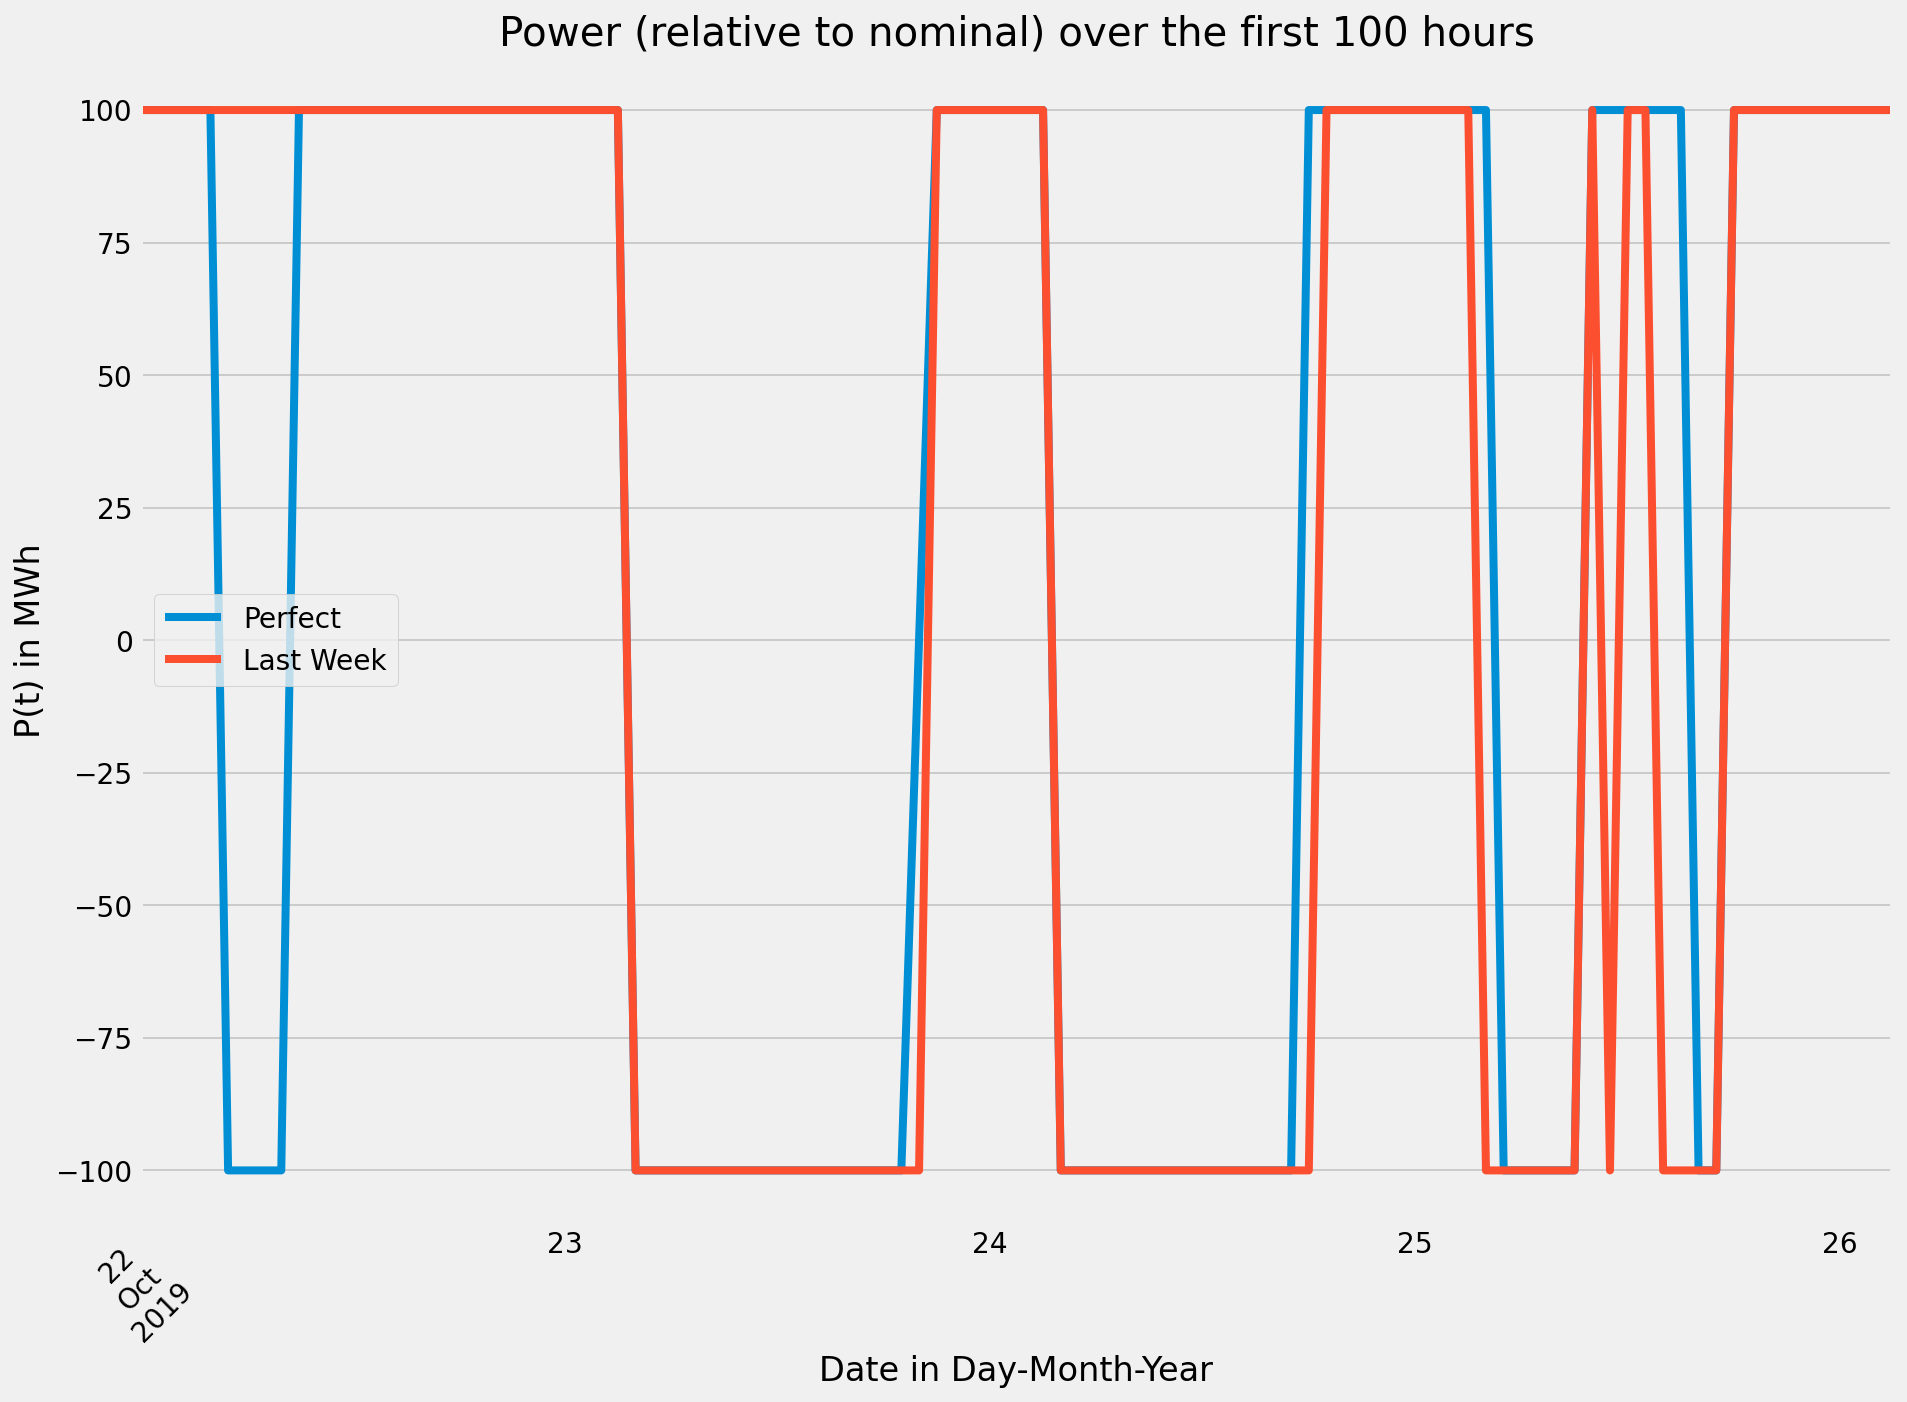

In [33]:
# Create dataframe that unifies the necessary information
df100hlast = results_lastweek[['Power']]
df100h = results_perfect[['Timeslot','Power']]
df100h = df100h.head(100)
df100h.columns = ['t','Perfect']
df100h['Last Week'] = df100hlast

# Plot data and assign attributes
ax = df100h.plot('t',['Perfect','Last Week'],title='Power (relative to nominal) over the first 100 hours',figsize=(14,10))
ax.set_ylabel("P(t) in MWh")
ax.set_xlabel("Date in Day-Month-Year")
ax.legend(title = "Prediction method")
plt.setp(ax.get_xticklabels(), rotation=45)
ax.legend(loc='best')
plt.show()

#### Plot E(t) for the first 100 hours

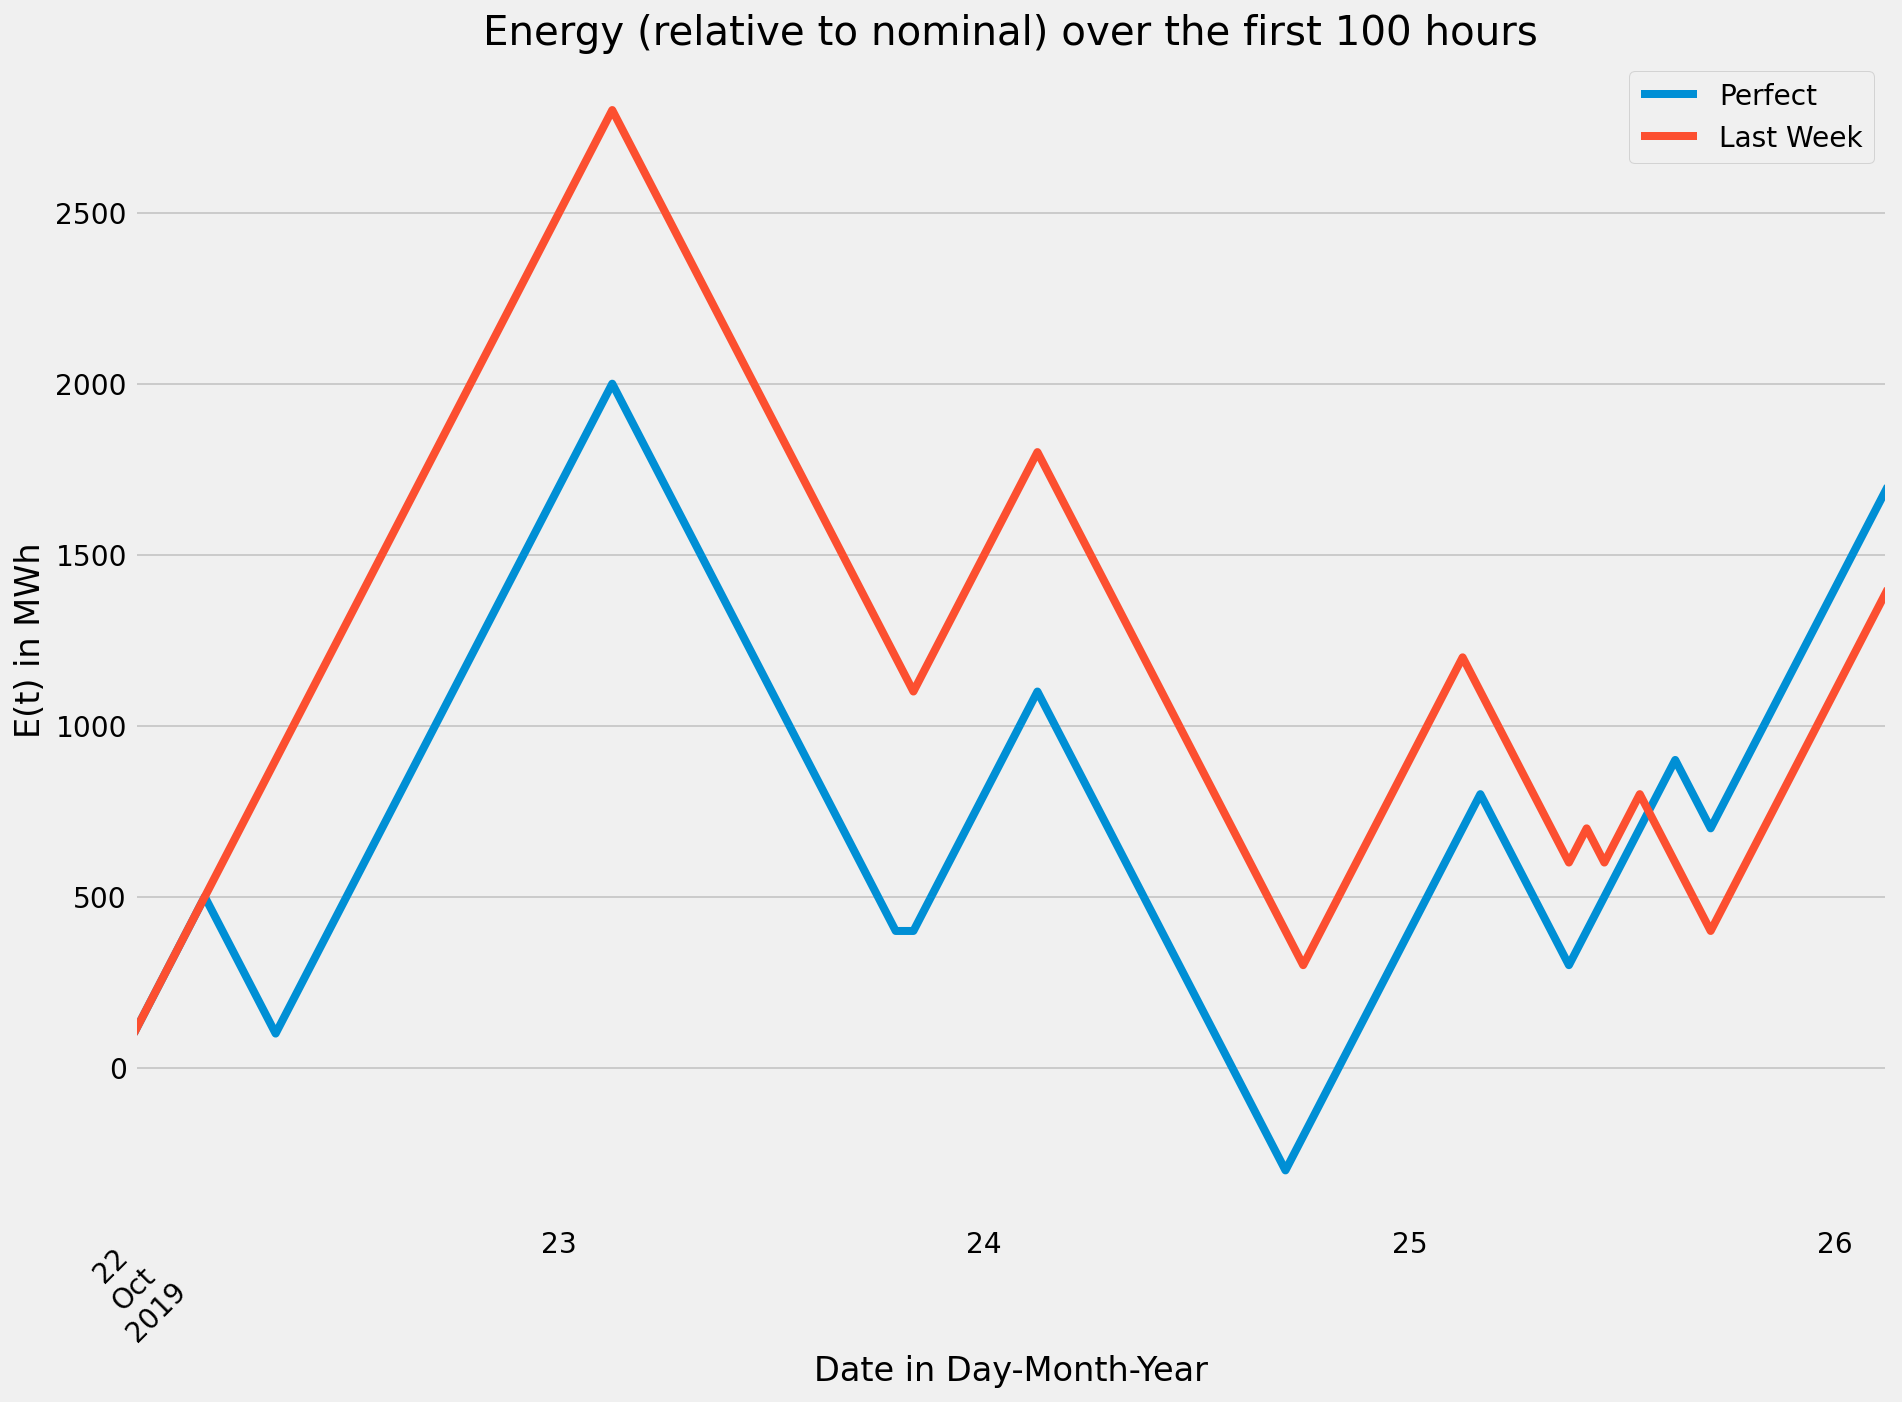

In [106]:
# Create dataframe that unifies the necessary information
df100hlastE = results_lastweek[['Energy']]
df100hE = results_perfect[['Timeslot','Energy']]
df100hE = df100hE.head(100)
df100hE.columns = ['t','Perfect']
df100hE['Last Week'] = df100hlastE

# Plot data and assign attributes
ax = df100hE.plot('t',['Perfect','Last Week'],title='Energy (relative to nominal) over the first 100 hours',figsize=(14,10))
ax.set_ylabel("E(t) in MWh")
ax.set_xlabel("Date in Day-Month-Year")
ax.legend(title = "Prediction method")
ax.legend(loc='best')
plt.setp(ax.get_xticklabels(), rotation=45)
plt.show()

#### Plot earnings

<ipython-input-107-0659abe3dee2>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfEa['Last Week'] = dflastEa
D:\Program Files\Anaconda\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


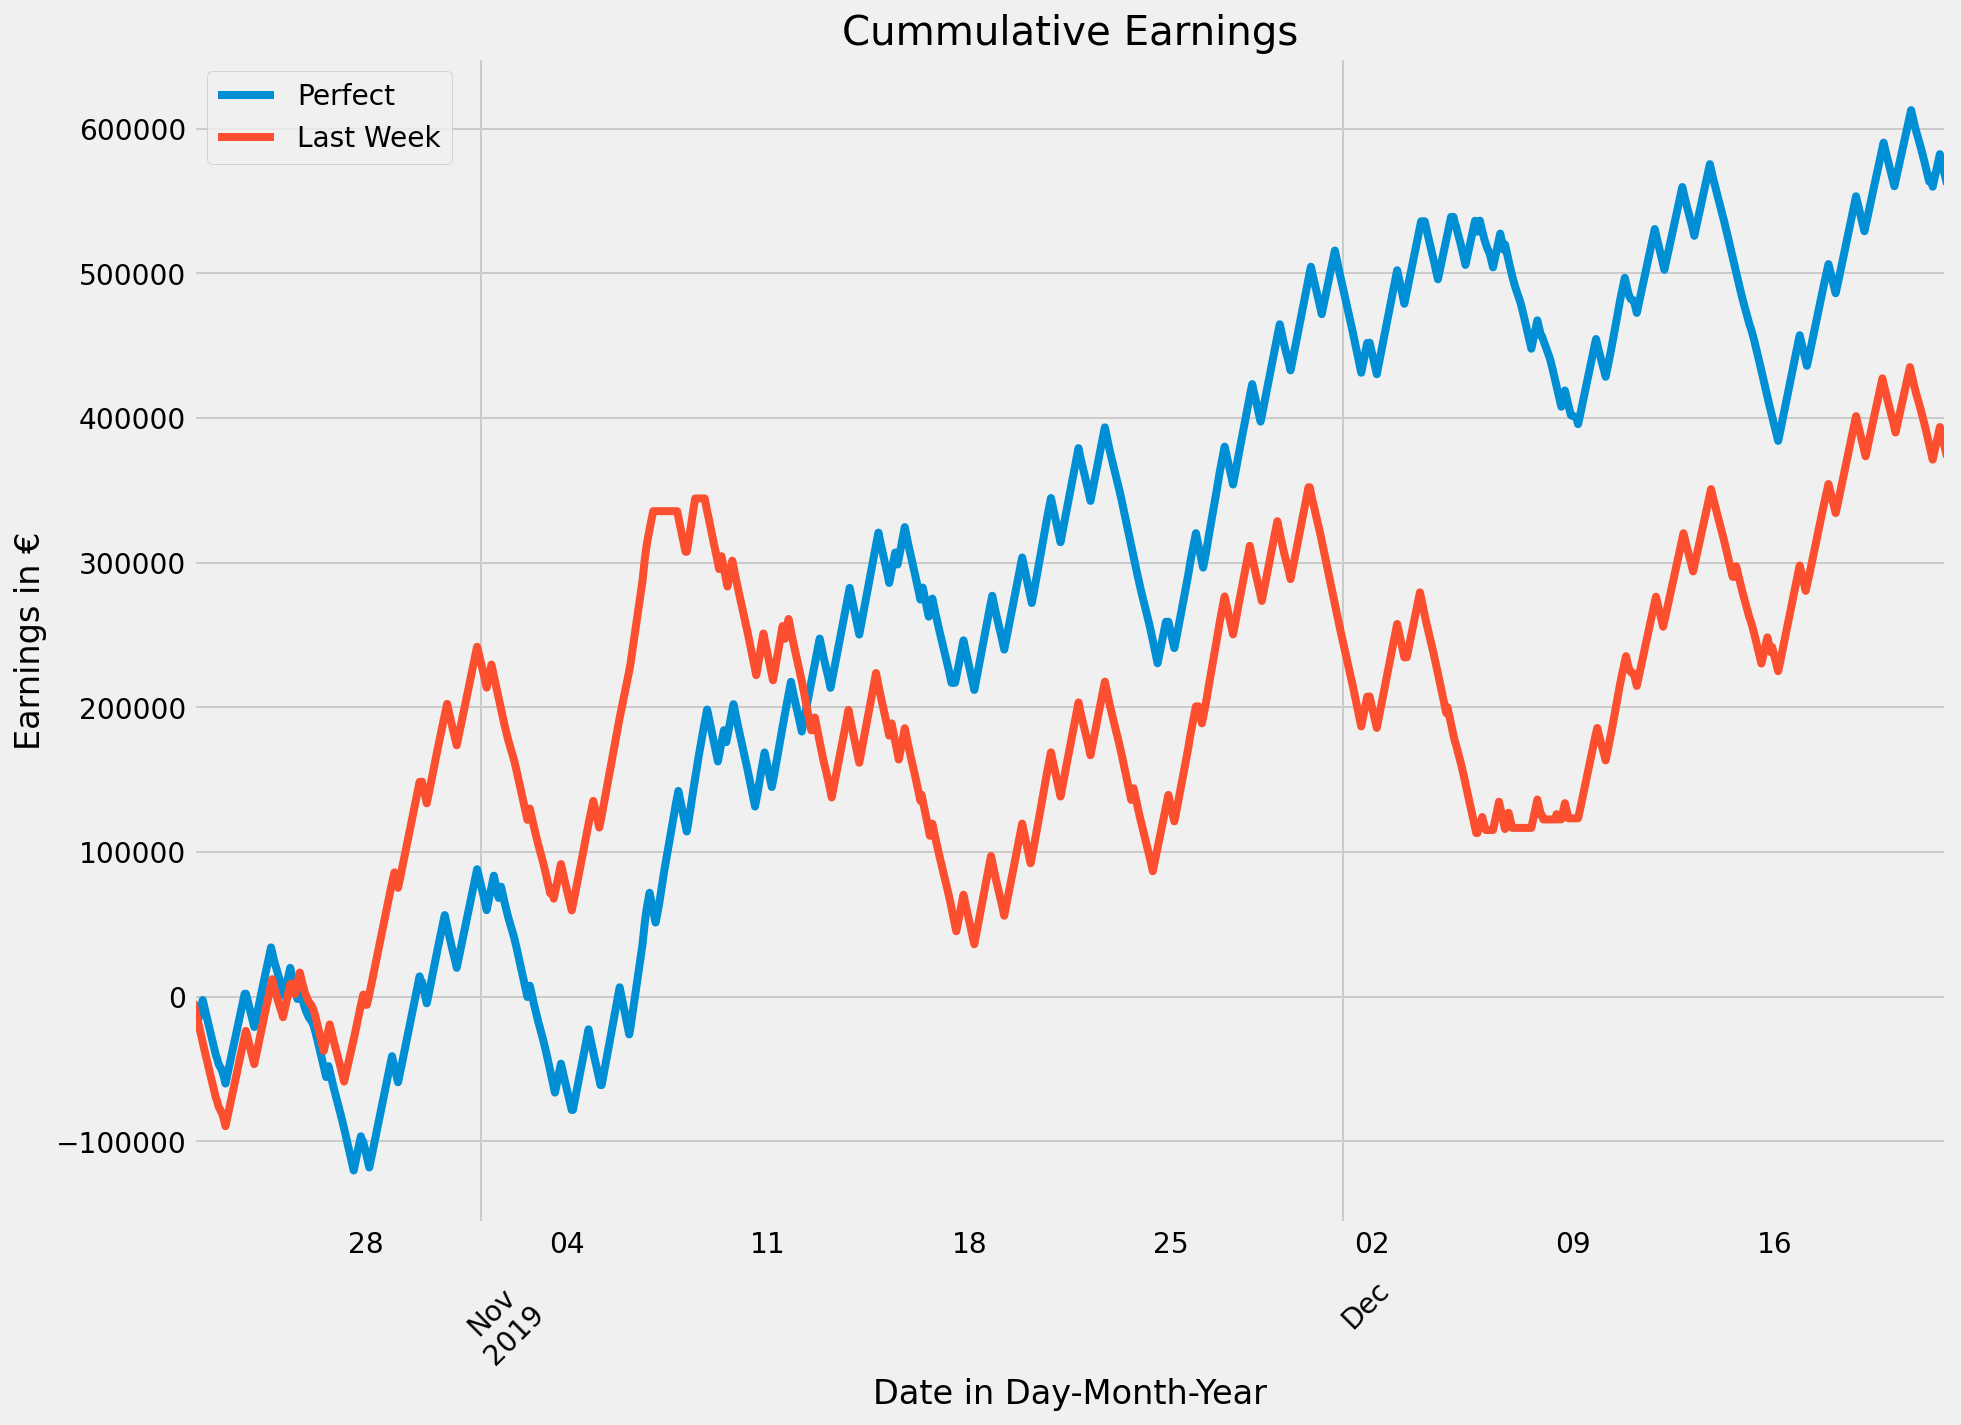

In [107]:
# Create dataframe that unifies the necessary information
dflastEa = results_lastweek[['Earnings']]
dfEa = results_perfect[['Timeslot','Earnings']]
dfEa.columns = ['t','Perfect']
dfEa['Last Week'] = dflastEa

# Compute cummulatative sum
lastPerfect = 0
lastLastWeek = 0
for index, row in dfEa.iterrows():
    if index != 0:
        dfEa.loc[index, 'Perfect']  += lastPerfect
        dfEa.loc[index, 'Last Week'] += lastLastWeek
    lastPerfect = dfEa.loc[index, 'Perfect']
    lastLastWeek = dfEa.loc[index, 'Last Week']

# Plot data and assign attributes    
ax = dfEa.plot('t',['Perfect','Last Week'],title='Cummulative Earnings', figsize=(14,10))
ax.set_ylabel("Earnings in €")
ax.set_xlabel("Date in Day-Month-Year")
ax.legend(title = "Prediction method")
ax.legend(loc='best')
plt.setp(ax.get_xticklabels(), rotation=45)
plt.show()

#### Average Power and electricity price for each hour of the day and each day of the week  
Please note that the second y axis is inverted. This is not a data viz course, so sue me

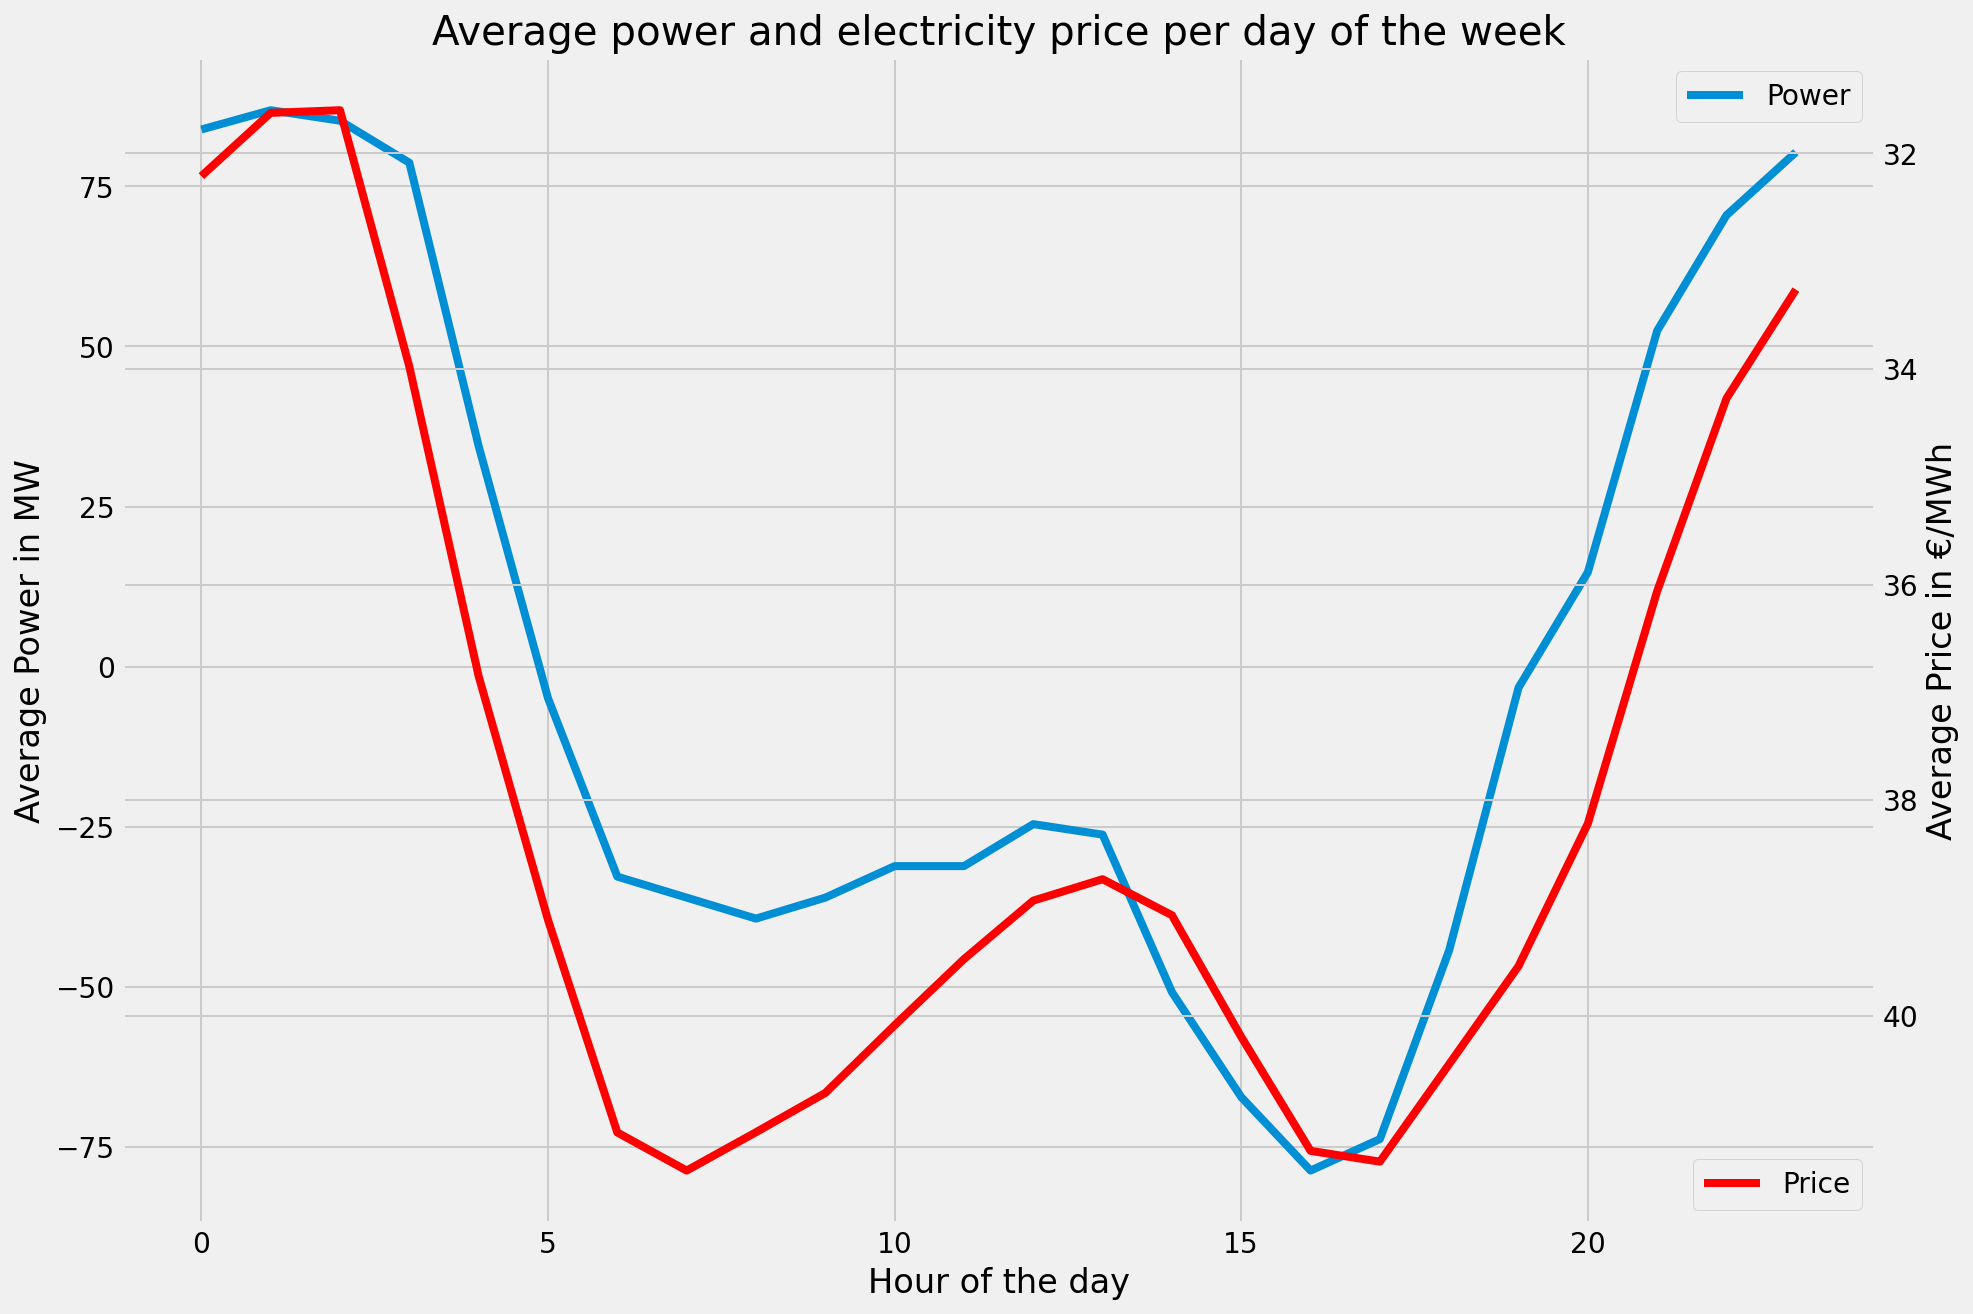

In [108]:
# Create dataframe that unifies the necessary information
results_dates = results_lastweek.copy(deep=True)
timestamps = results_dates.index
for index, row in results_dates.iterrows():
    results_dates.loc[index, 'Date'] = results_dates.loc[index, 'Timeslot'].hour

grouped_res = results_dates.groupby(['Date']).mean()
grouped_res = grouped_res[['Power']]

prices = df[["SE1"]].copy(deep=True)

for index, row in prices.iterrows():
    prices.loc[index, 'Weekday'] = index.hour
grouped_pric = prices.groupby(['Weekday']).mean()
grouped_pric = grouped_pric[['SE1']]

# Plot data and assign attributes  
ax = grouped_res.plot(title='Average power and electricity price per day of the week',figsize=(14,10))
ax.set_ylabel("Average Power in MW")
ax.set_xlabel("Hour of the day")
ax2 = ax.twinx()
ax2.plot(grouped_pric, color="red", label = "Price")
ax.legend(loc='upper right')
ax2.invert_yaxis()
ax2.set_ylabel("Average Price in €/MWh")
ax2.legend(loc='lower right')
plt.show()

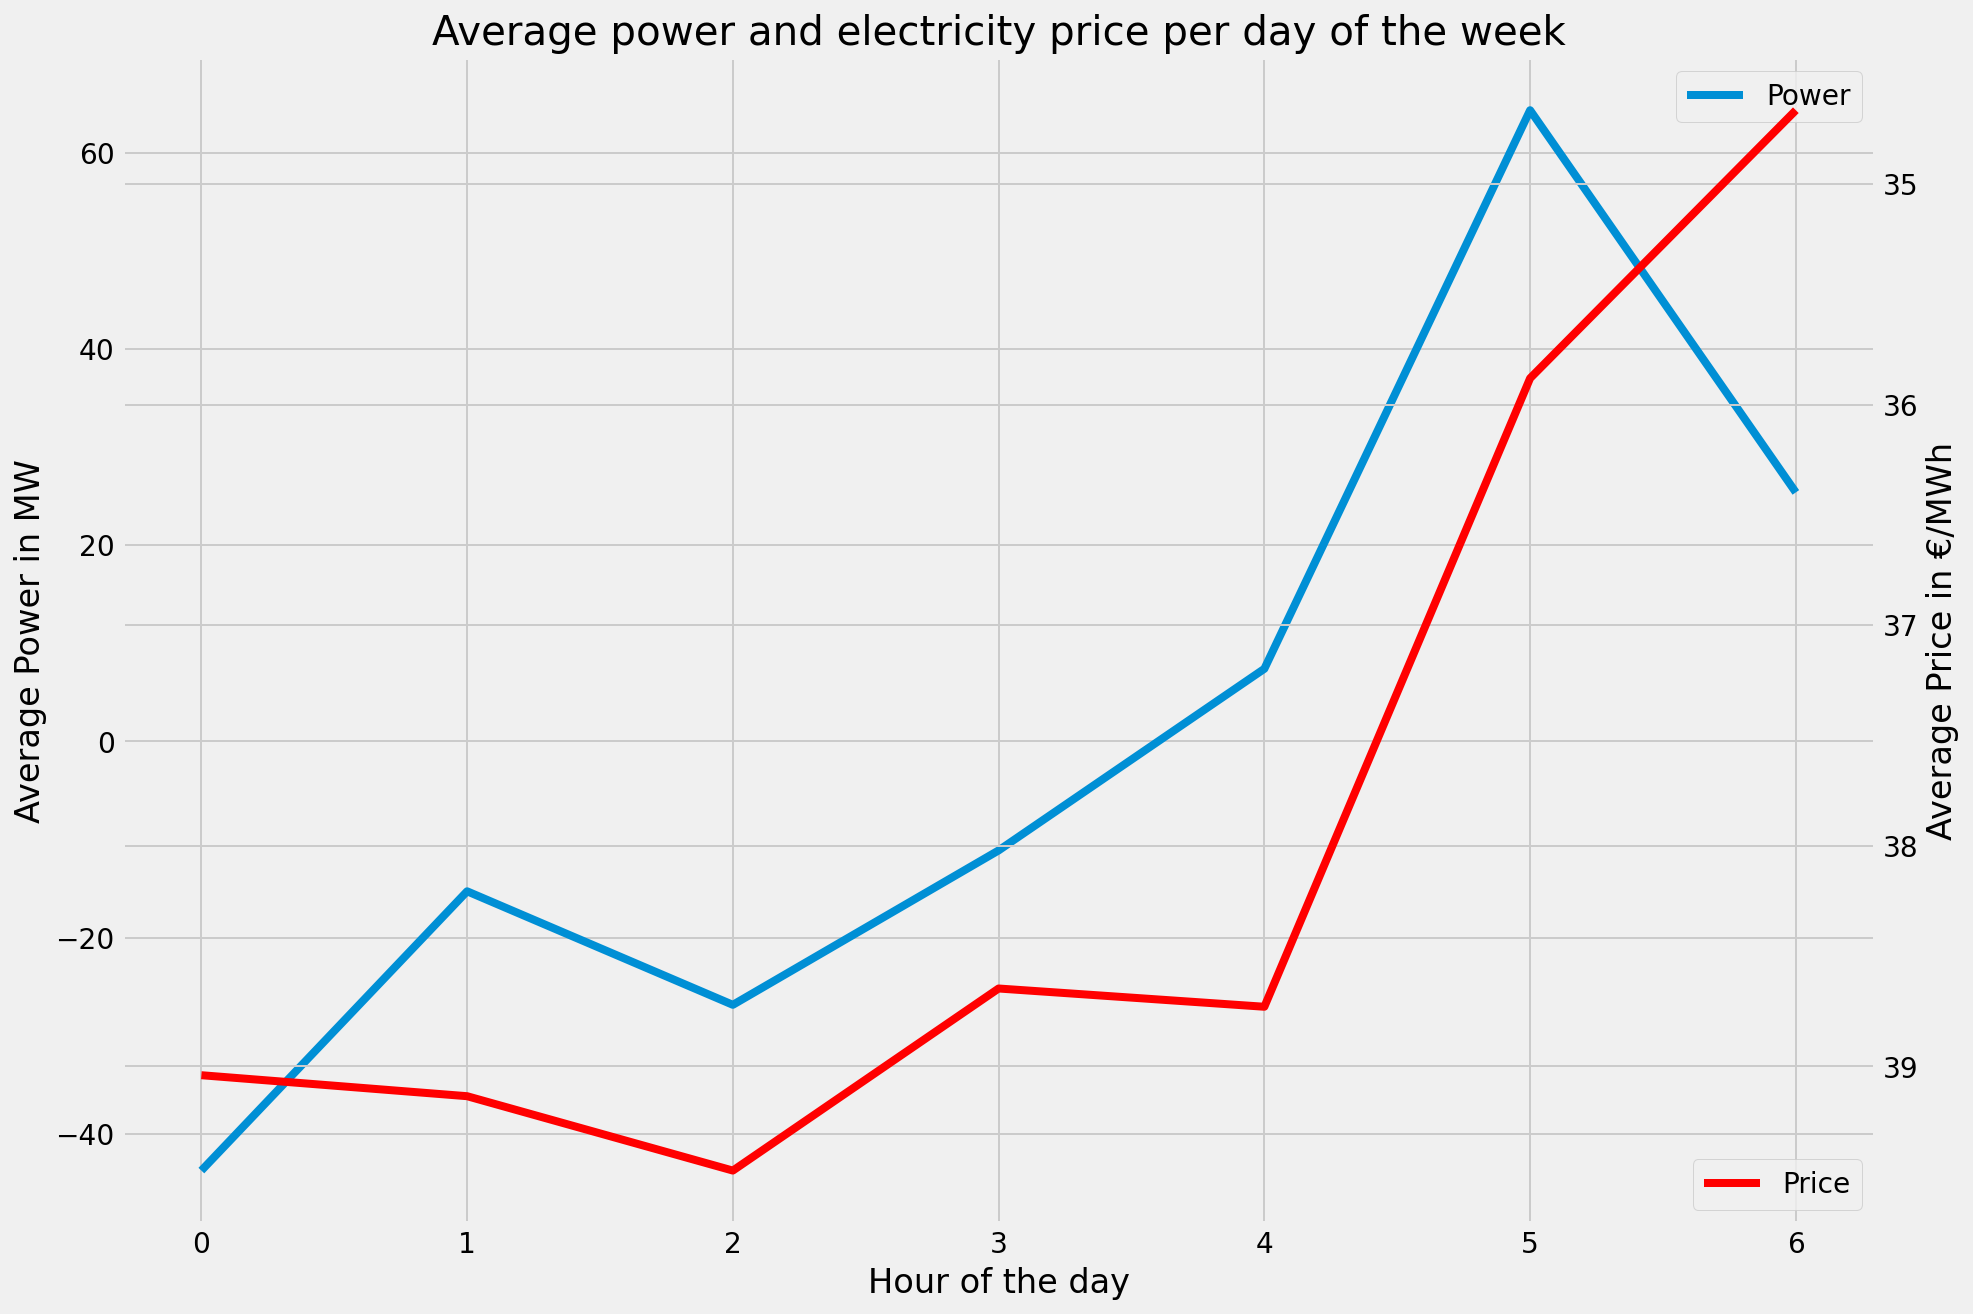

In [109]:
# Create dataframe that unifies the necessary information
results_dates = results_lastweek.copy(deep=True)
timestamps = results_dates.index
for index, row in results_dates.iterrows():
    results_dates.loc[index, 'Date'] = results_dates.loc[index, 'Timeslot'].weekday()
grouped_res = results_dates.groupby(['Date']).mean()
grouped_res = grouped_res[['Power']]

prices = df[["SE1"]].copy(deep=True)

for index, row in prices.iterrows():
    prices.loc[index, 'Weekday'] = index.weekday()
grouped_pric = prices.groupby(['Weekday']).mean()
grouped_pric = grouped_pric[['SE1']]

# Plot data and assign attributes  
ax = grouped_res.plot(title = 'Average power and electricity price per day of the week',figsize=(14,10))
ax.set_ylabel("Average Power in MW")
ax.set_xlabel("Hour of the day")
ax2 = ax.twinx()
ax2.plot(grouped_pric, color="red", label = "Price")
ax2.invert_yaxis()
ax2.set_ylabel("Average Price in €/MWh")
ax.legend(loc = 'upper right')
ax2.legend(loc = 'lower right')
plt.show()

#### Plot actual E(t) for the first week versus E(t) from first iteration of optimization

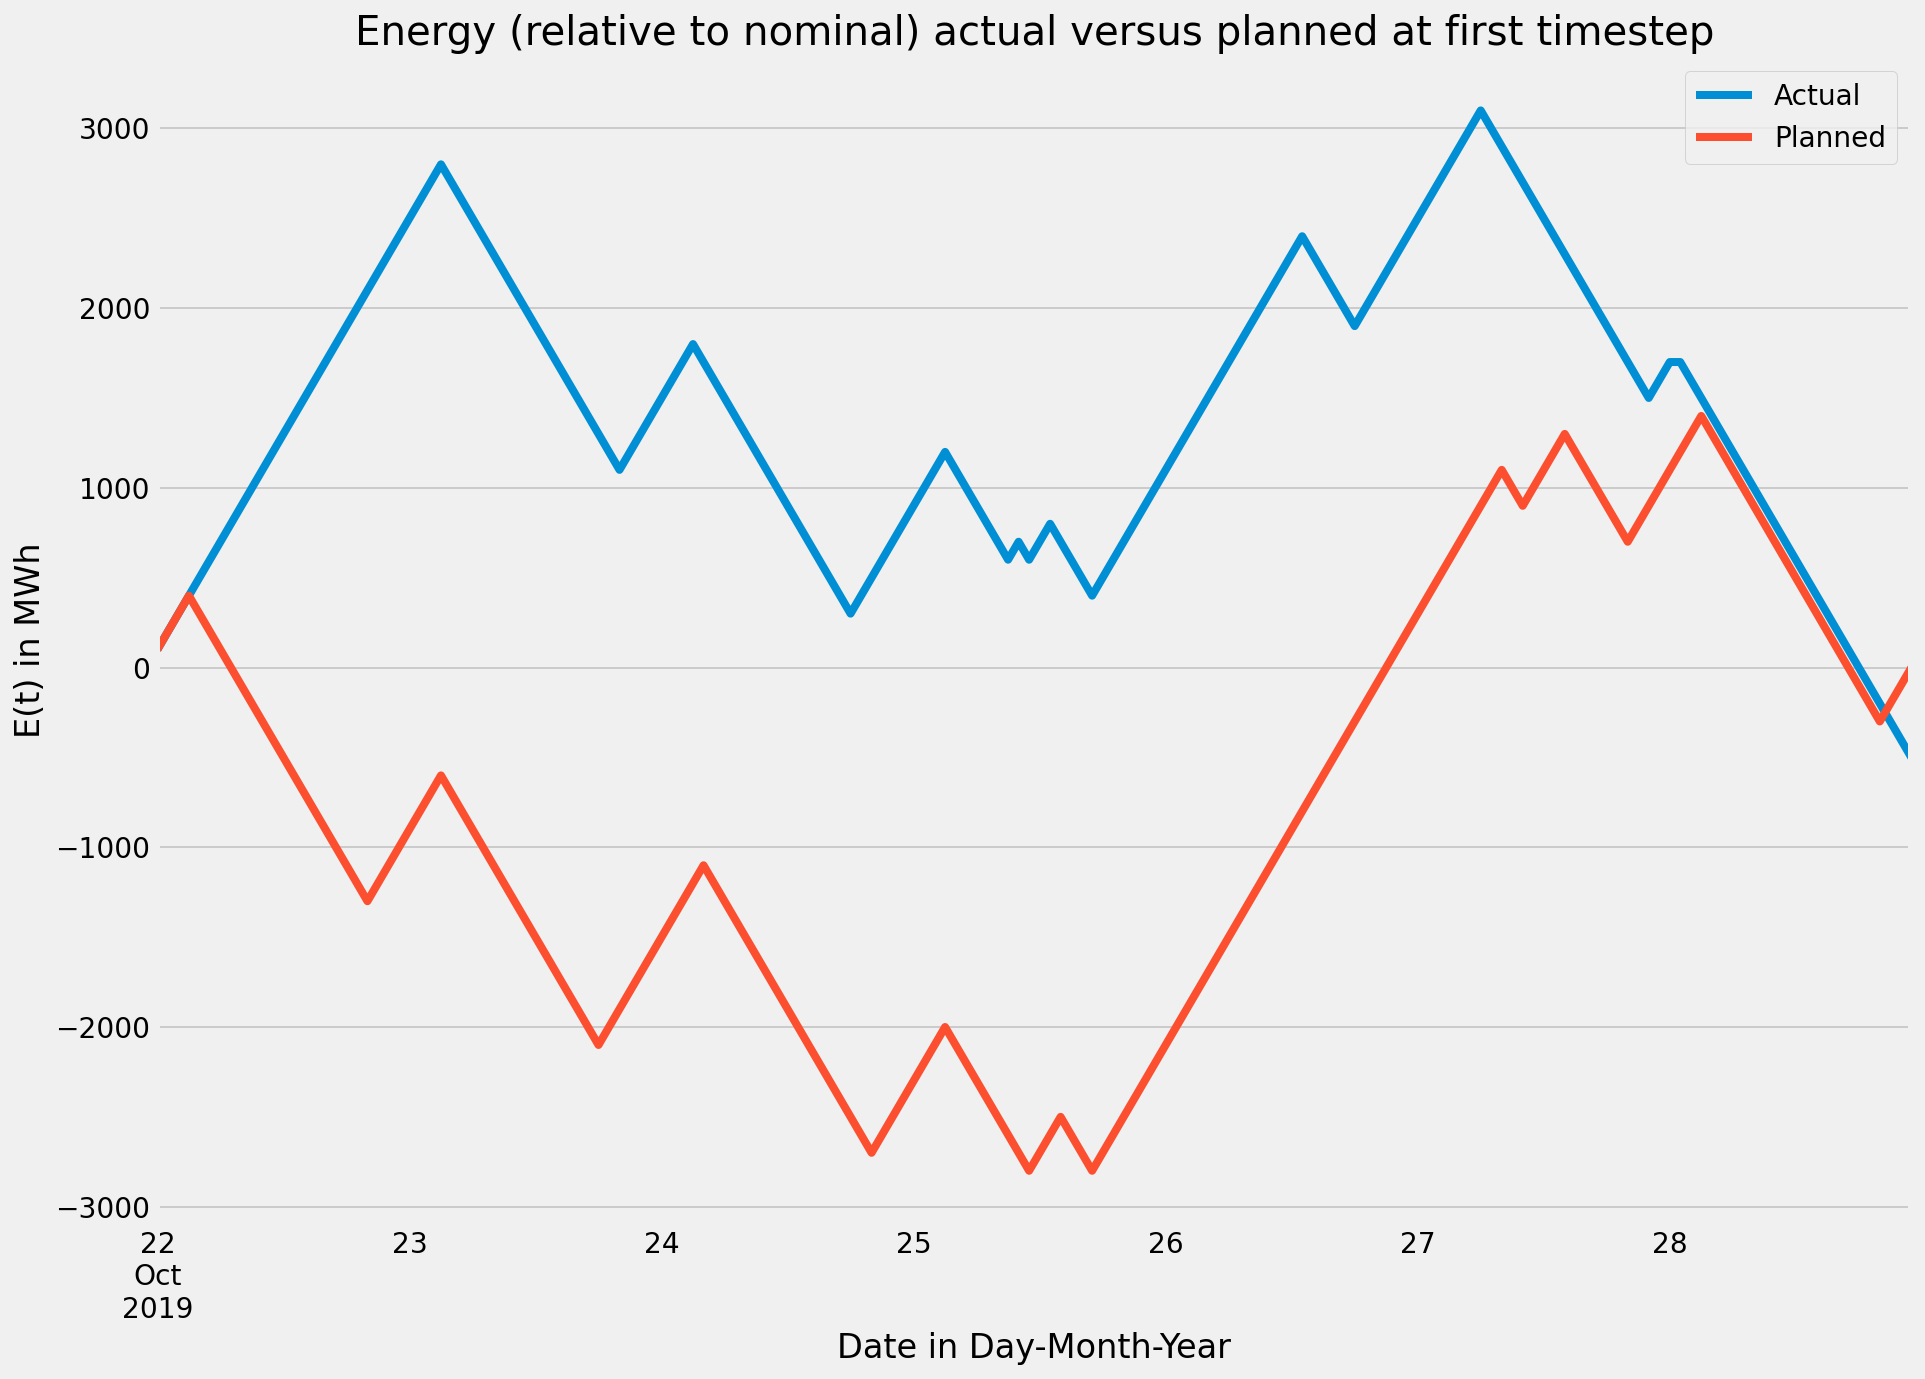

In [110]:
# Create dataframe that unifies the necessary information
df168hE = results_lastweek[['Timeslot','Energy']]
df168hE = df168hE.head(168)
df168hE.columns = ['t','Actual']

predictor = PredictionGenerator(historic_prices, method="SameHourLastWeek")
prices = predictor.predict(t_start, t_horizon)
prices[t_start] = historic_prices[t_start]

model = solve(prices,Pmax,Emax,E0)

for index, row in df168hE.iterrows():
    df168hE.loc[index, 'Planned'] = model.getVarByName("E%s" % df168hE.loc[index, 't']).x

# Plot data and assign attributes  
ax = df168hE.plot('t',['Actual', 'Planned'],title='Energy (relative to nominal) actual versus planned at first timestep', figsize=(14,10))
ax.set_ylabel("E(t) in MWh")
ax.set_xlabel("Date in Day-Month-Year")
plt.show()